In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

########################
# Find qslam modules
########################
sys.path.append('../qslam/')
sys.path.append('../paduaq/')

from hardware import Node
from visualiserisk import cm2inch, HEATMAP
from riskanalysis import EngineeredTruth
from true_functions import true_function, generate_data_qubits_coords

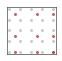

In [2]:
# Add an extra case corresponding to simple assignment

data_qubits = generate_data_qubits_coords(25, flag='uniform')
sensing_qubits = [(x, 0.75) for x in [-0.75, 0.25, 1.0]] + [(x, -0.25) for x in [-0.75, 0.25, 1.0]]
sensing_qubits += [(x, -1.) for x in [-0.75, 0.25, 1.0]]
sensing_qubits = sensing_qubits[::-1]


plt.figure(figsize=(cm2inch(2.2),cm2inch(2.2)))

plt.plot(np.asarray(data_qubits)[:,0],np.asarray(data_qubits)[:,1], '.',
         markeredgecolor='darkgrey', 
         markerfacecolor='darkgrey',
         label="Data Qubits", ms=4, alpha=.5)

plt.plot(np.asarray(sensing_qubits)[:,0], np.asarray(sensing_qubits)[:,1], '.',
         markeredgecolor='darkred', 
         markerfacecolor='darkred',
         label="Sensor Qubits", ms=4, alpha=0.5)

plt.xticks([])
plt.yticks([])
plt.savefig('data_figs/SimpleAss.svg', format='svg', dpi=400)
plt.show()


In [3]:
GROUP={}

GROUP['(-0.75, -1.0)'] = [0, 1]
GROUP['(0.25, -1.0)'] = [2, 3]
GROUP['(1.0, -1.0)'] = [4]

GROUP['(-0.75, -0.25)'] = [5, 6, 10, 11]
GROUP['(0.25, -0.25)'] = [7, 8, 12, 13]
GROUP['(1.0, -0.25)'] = [9, 14]

GROUP['(-0.75, 0.75)'] = [15, 16, 20, 21]
GROUP['(0.25, 0.75)'] = [17, 18, 22, 23]
GROUP['(1.0, 0.75)'] = [19, 24]

for key in GROUP.keys():
    print "For sensor at:", key
    print "Set data qubits as neighbours at:"
    print np.asarray(data_qubits)[GROUP[key]]
    print
    print

For sensor at: (-0.75, -0.25)
Set data qubits as neighbours at:
[[-1.  -0.5]
 [-0.5 -0.5]
 [-1.   0. ]
 [-0.5  0. ]]


For sensor at: (1.0, -0.25)
Set data qubits as neighbours at:
[[ 1.  -0.5]
 [ 1.   0. ]]


For sensor at: (1.0, 0.75)
Set data qubits as neighbours at:
[[1.  0.5]
 [1.  1. ]]


For sensor at: (-0.75, 0.75)
Set data qubits as neighbours at:
[[-1.   0.5]
 [-0.5  0.5]
 [-1.   1. ]
 [-0.5  1. ]]


For sensor at: (1.0, -1.0)
Set data qubits as neighbours at:
[[ 1. -1.]]


For sensor at: (0.25, 0.75)
Set data qubits as neighbours at:
[[0.  0.5]
 [0.5 0.5]
 [0.  1. ]
 [0.5 1. ]]


For sensor at: (-0.75, -1.0)
Set data qubits as neighbours at:
[[-1.  -1. ]
 [-0.5 -1. ]]


For sensor at: (0.25, -1.0)
Set data qubits as neighbours at:
[[ 0.  -1. ]
 [ 0.5 -1. ]]


For sensor at: (0.25, -0.25)
Set data qubits as neighbours at:
[[ 0.  -0.5]
 [ 0.5 -0.5]
 [ 0.   0. ]
 [ 0.5  0. ]]




In [4]:
def simple_assignment_map(empirical_estimate, 
                          all_qubit_locations,
                          sensing_qubits, 
                          GROUP_ASSIGNMENT_DICT):
    
    for idx_sensor in sensing_qubits:
        
        
        coords = all_qubit_locations[idx_sensor]
        neighbours = GROUP_ASSIGNMENT_DICT[str(coords)] 
        
#         print "For sensor index:", idx_sensor,"and coords", coords
        
        for idx_neighbour in neighbours:
            
            idx_data_qubit = idx_neighbour + len(sensing_qubits)
#             print "----> assigning neighbour:", idx_data_qubit, " with coords", all_qubit_locations[idx_data_qubit]
#             print "------------ the value of:", empirical_estimate[idx_sensor]
#             print "------------ replacing previous value:", empirical_estimate[idx_data_qubit]
            
            empirical_estimate[idx_data_qubit] = empirical_estimate[idx_sensor]
    
    return empirical_estimate

In [5]:
class SimpleAssignmentEstimator(object):
    '''
    Computes expected value of estimated map error using simple assignment strategy.
    Simulated measurements generated from an EngineeredTruth instance.

    Attributes:
    -----------
    msmt_per_node (`dtype` | scalar int):
        Number of measurements per qubit per iteration before information is
            exchanged with neighbours.
    numofnodes (`dtype` | scalar int):
        Total number of qubit locations.
    max_num_iterations (`dtype` | scalar int):
        Max number of iterations for a qslam algorithm.
        A single control directive corressponds to one iteration.
    truth_generator (`dtype` | RealData class instance):
        A EngineeredTruth class object instance.
    empirical_estimate (`dtype` | numpy array):
        Reconstructed map using simple assignment strategy.
        Dims: numofnodes.


    Class Methods:
    --------------
    total_msmt_budget : Return total msmt budget given algorithm configurations.
    get_empirical_est : Return reconstructed map from Naive measurement strategy.
    '''
    def __init__(self,
                 TRUTHKWARGS,
                 msmt_per_node=1,
                 numofnodes=25,
                 data_qubits_indicies=None, 
                 intepolationflag='simple_assignment',
                 max_num_iterations=None):
        
        self.msmt_per_node = msmt_per_node
        self.numofnodes = numofnodes
        self.max_num_iterations = max_num_iterations
        self.truth_generator = EngineeredTruth(self.numofnodes, TRUTHKWARGS)

        # PADUA
        self.data_qubits_indicies = data_qubits_indicies
        self.intepolationflag = intepolationflag
        self.all_qubit_locations = None
        if self.intepolationflag is not None:
            self.all_qubit_locations = self.truth_generator.TRUTHKWARGS["all_qubit_locations"]

        self.empirical_estimate = None

        self.__total_msmt_budget = self.msmt_per_node * self.max_num_iterations

    @property
    def total_msmt_budget(self):
        return self.msmt_per_node * self.max_num_iterations
    
    def get_empirical_est(self, GROUP_ASSIGNMENT_DICT):

        phase_map = self.truth_generator.get_map()

        num_of_sensing_nodes = self.numofnodes
        
        sensing_qubits = np.arange(num_of_sensing_nodes)
        
        if self.data_qubits_indicies is not None:
            sensing_qubits = np.asarray(list(set(sensing_qubits) - set(self.data_qubits_indicies)))
            num_of_sensing_nodes = len(sensing_qubits)

        mask = np.zeros(self.numofnodes, dtype=bool) # Mask for hiding all values.
        if num_of_sensing_nodes <= self.max_num_iterations:

            if self.max_num_iterations / num_of_sensing_nodes == self.msmt_per_node:
                mask[sensing_qubits] = True
            if self.max_num_iterations / num_of_sensing_nodes != self.msmt_per_node:
                self.msmt_per_node = int(self.total_msmt_budget / num_of_sensing_nodes)
                mask[sensing_qubits] = True

        if num_of_sensing_nodes > self.max_num_iterations:
            randomly_choose = np.random.choice(sensing_qubits, self.max_num_iterations, replace=False)
            mask[randomly_choose] = True

        # Final set of qubits that are measured under a Naive Approach
        final_measured_qubits = np.arange(self.numofnodes)[mask]
        self.empirical_estimate = np.ones(self.numofnodes) * np.random.random_sample(size=1) * np.pi

        for idx_node in final_measured_qubits:

            single_shots = [Node.quantiser(Node.born_rule(phase_map[idx_node])) for idx_shot in range(self.msmt_per_node)]
            self.empirical_estimate[idx_node] = Node.inverse_born(np.mean(np.asarray(single_shots, dtype=float)))

        # Add interpolation for unmeasured data qubits.
        if self.data_qubits_indicies is not None and self.intepolationflag is not None:

            f_data =  self.empirical_estimate[sensing_qubits]
            data_points = np.asarray([self.all_qubit_locations[idx_point] for idx_point in sensing_qubits])
            test_points = np.asarray([self.all_qubit_locations[idx_point] for idx_point in self.data_qubits_indicies])
            
            if isinstance(self.intepolationflag, str): 
                
                if self.intepolationflag == 'simple_assignment':
                    
                    self.empirical_estimate = simple_assignment_map(self.empirical_estimate, 
                                                                    self.all_qubit_locations,
                                                                    sensing_qubits, 
                                                                    GROUP_ASSIGNMENT_DICT) 
        return self.empirical_estimate, phase_map

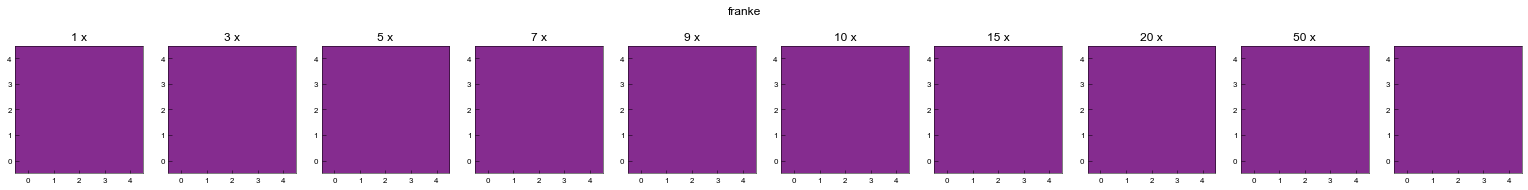

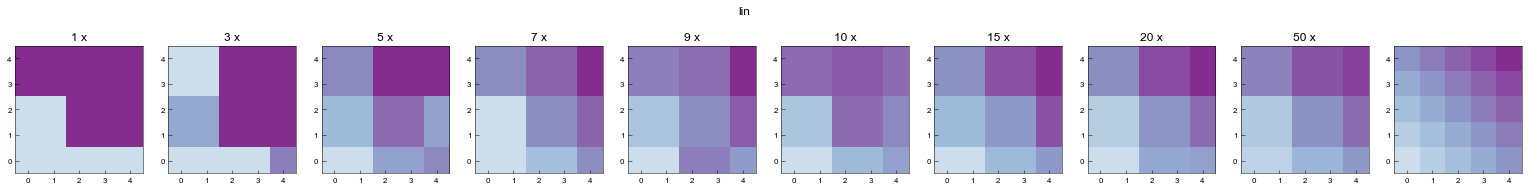

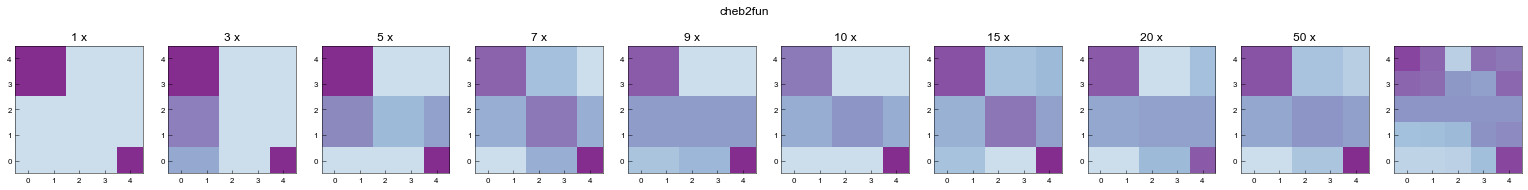

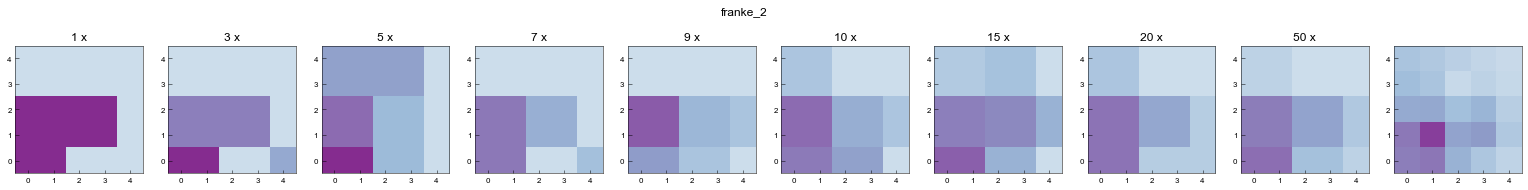

In [6]:
TRUTHKWARGS = {}
TRUTHKWARGS["truthtype"] = "UseFunction"
TRUTHKWARGS["true_function"] = true_function
TRUTHKWARGS["all_qubit_locations"] = sensing_qubits + data_qubits

Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]
num_of_nodes = len(TRUTHKWARGS["all_qubit_locations"])
data_qubits_indicies=np.arange(num_of_nodes)[len(sensing_qubits) : ]
interpolation_flag='simple_assignment'
trials=50

truth_types = ['franke', 'lin', 'cheb2fun', 'franke_2']

estimated_map_matrix = np.zeros((len(truth_types), len(Multiples), trials, num_of_nodes))
residuals_err_matrix = np.zeros((len(truth_types), len(Multiples), trials, num_of_nodes))


for idx_truth in range(len(truth_types)):
    
    true_function_type = truth_types[idx_truth]
    
    TRUTHKWARGS["true_function_type"] = true_function_type
    
    fig, axes = plt.subplots(1,len(Multiples) + 1, figsize=(len(Multiples)*3, 3))
    
    fig.suptitle(true_function_type)
    
    for idx_msmt_var in range(len(Multiples)):    

        max_num_iterations=len(sensing_qubits) * Multiples[idx_msmt_var]

        for idx_run in range(trials):

            test_object = SimpleAssignmentEstimator(TRUTHKWARGS,
                                                    msmt_per_node=1,
                                                    numofnodes=num_of_nodes,
                                                    data_qubits_indicies=data_qubits_indicies,
                                                    intepolationflag=interpolation_flag,
                                                    max_num_iterations=max_num_iterations)

            estimated_vals, phase_map = test_object.get_empirical_est(GROUP)

            estimated_map_matrix[idx_truth, idx_msmt_var, idx_run, : ] = estimated_vals
            residuals_err_matrix[idx_truth, idx_msmt_var, idx_run, : ] = estimated_vals - phase_map
        
        axes[idx_msmt_var].imshow(estimated_vals[len(sensing_qubits) :].reshape(5,5), **HEATMAP)
        axes[idx_msmt_var].set_title("%s x" %(Multiples[idx_msmt_var]))
    
    axes[-1].imshow(phase_map[len(sensing_qubits) :].reshape(5,5),**HEATMAP)
    
    plt.show()

In [7]:
np.savez('SimpleAssigmentResults.npz', 
         estimated_map_matrix=estimated_map_matrix, 
         residuals_err_matrix=residuals_err_matrix)